In [1]:
import sys
sys.path.insert(0, '../')
from utils.GraphAnalytics import GraphAnalytics
from models.Node2Vec import GraphNode2Vec
import numpy as np
import pandas as pd

In [2]:
g = GraphAnalytics()
g.load_graph('../data/full_graph')

In [3]:
#while this method causes slower convergence because of the lack of prior, it is still a very healthy train
mu, sigma = 0, .1 # mean and standard deviation
final_embeddings = dict(zip(list(g.nodes),(np.random.normal(mu, sigma, 128) for i in range(len(g.nodes))))) #randomly making embedded nodes

### StellarGraph implementation

https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/hinsage-link-prediction.html

In [4]:
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from stellargraph.utils import plot_history
from tensorflow.keras import Model, optimizers, losses, metrics
from tensorflow import keras
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [5]:
#load in with original node2vec embeddings
st_g = g.as_undigraph.copy()
nx.set_node_attributes(
    st_g,
    final_embeddings,
    'node2vec_embeddings',
)
st_g = StellarGraph.from_networkx(st_g, node_features='node2vec_embeddings')

In [6]:
#the two really important hyper parameters are different in graph than traditional ML
#test_pred_target_edge_count determines how many of the target edges we drop to later use as test data to evaluate prediction accuracy
#the next cell block ALSO negativly samples nodes without the target edge and trains binary classification between the two node to node datasets
test_pred_target_edge_count = .3
#train_pred_target_edge_count is used to sub sample from the test graph, NOT the original graph
#train_pred_target_edge_count determines how many of the target edges we drop to use in training, aka finding optima via SGD and backprop
#we feed in the drop edges as training data, just like you would feed in labels with a feature set
train_pred_target_edge_count = .99999#0.5
#However! There are still some target edges remaining in the graph. The amount is orig_graph_target_edges * test_pred_target_edge_count * train_pred_target_edge_count
#these remaining target edges are now FEATURES instead of labels. The G_train subgraph can use them in training it's edge prediction classification task
#confused me at first as it adds an additional element of splitting to traditional ML.
#IMO the main reason is that labels can be features. This especially important in time sries graphs, where you may know an acqusition had happened in the previous timestep
#then an LSTM would benefit from that prior state knowledge and make the right adjustment
org_target_count = len([_ for _ in st_g.edges(include_edge_type=True) if _[2]=='ACQUIRED'])
test_target_count = int(org_target_count*(1-test_pred_target_edge_count))
train_target_count = int(test_target_count*(1-train_pred_target_edge_count))

print('Original Target Edges',org_target_count)
print('Target Edges to be held in test dataset, unseen by training, and later used in evaluation', org_target_count-test_target_count)
print('Target Edges to be held in train dataset, used by backprop to opto', test_target_count-train_target_count)
print('Remaining Target Edges turned into features',train_target_count)
#when running the edgesplitter, the test edge splitter should be close to this number, and same with train
num_workers = -1

Original Target Edges 2985
Target Edges to be held in test dataset, unseen by training, and later used in evaluation 896
Target Edges to be held in train dataset, used by backprop to opto 2089
Remaining Target Edges turned into features 0


In [7]:
edge_splitter_test = EdgeSplitter(st_g)
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_pred_target_edge_count, method="global", edge_label='ACQUIRED'
)
#setting keep connected as false because
#ValueError: Unable to sample 298 positive edges (could only sample 90 positive edges). Consider using smaller value for p or set keep_connected=False

#this produced edge_ids_test which is a subgraph of original, missing test_pred_target_edge_count of target edges
#and edge_labels_test which is a dataset if positive labels 1 (the acquired edge exists),
#and negative samples, the acquired edge doesn't exist 0
#can bassically run G_test as your training data
#can see when comparing info

Network has 2985 edges of type ACQUIRED
Network has 2985 edges of type ACQUIRED
** Sampled 895 positive and 895 negative edges. **


In [8]:
edge_splitter_test = EdgeSplitter(G_test)
G_train, edge_ids_train, edge_labels_train = edge_splitter_test.train_test_split(
    p=train_pred_target_edge_count, method="global", edge_label='ACQUIRED'
)

Network has 2090 edges of type ACQUIRED
Network has 2090 edges of type ACQUIRED
** Sampled 2089 positive and 2089 negative edges. **


In [9]:
print(edge_ids_test.shape, edge_labels_test.shape)

(1790, 2) (1790,)


In [10]:
print('Sanity check')
for _g in [st_g, G_test, G_train]:
    print(len([_ for _ in _g.edges(include_edge_type=True) if _[2]=='ACQUIRED']))
    #print(_g.info())

Sanity check
2985
2090
1


### Creation of the model

In [11]:
batch_size = 750
epochs = 200
num_samples=[4]

### Better Train Test Split Methadoloy
https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html

In [12]:
test_generator = HinSAGELinkGenerator(st_g, batch_size=batch_size,
                                      num_samples=num_samples,
                                      head_node_types=["Company", "Company"])
test_gen = test_generator.flow(edge_ids_test, edge_labels_test)

In [13]:
train_generator = HinSAGELinkGenerator(G_train, batch_size=batch_size,
                                       num_samples=num_samples,
                                       head_node_types=["Company", "Company"])
train_gen = train_generator.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [14]:
hinsage_layer_sizes = [32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=train_generator, bias=True, dropout=0.4
)
x_inp, x_out = hinsage.in_out_tensors()

In [15]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [16]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(lr=.005),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy'],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4, 128)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4, 128)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 4, 128)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4, 128)]     0                                            
______________________________________________________________________________________________

In [17]:
init_train_metrics = model.evaluate(train_gen)
init_test_metrics = model.evaluate(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3/3 [==============================] - 1s 153ms/step - loss: 4.2071 - accuracy: 0.5022

Train Set Metrics of the initial (untrained) model:
	loss: 4.3860
	accuracy: 0.5057

Test Set Metrics of the initial (untrained) model:
	loss: 4.2071
	accuracy: 0.5022


In [18]:
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=test_gen,
                    use_multiprocessing=True,
                    verbose=2,
                    workers=num_workers)

Epoch 1/200
6/6 - 5s - loss: 4.0919 - accuracy: 0.5036 - val_loss: 2.7980 - val_accuracy: 0.5089
Epoch 2/200
6/6 - 2s - loss: 2.7474 - accuracy: 0.5096 - val_loss: 1.1541 - val_accuracy: 0.5374
Epoch 3/200
6/6 - 2s - loss: 1.3930 - accuracy: 0.5323 - val_loss: 0.7493 - val_accuracy: 0.5503
Epoch 4/200
6/6 - 2s - loss: 0.8592 - accuracy: 0.5419 - val_loss: 0.7142 - val_accuracy: 0.5274
Epoch 5/200
6/6 - 2s - loss: 0.7373 - accuracy: 0.5572 - val_loss: 0.7272 - val_accuracy: 0.5229
Epoch 6/200
6/6 - 2s - loss: 0.7018 - accuracy: 0.5627 - val_loss: 0.7439 - val_accuracy: 0.5128
Epoch 7/200
6/6 - 2s - loss: 0.6926 - accuracy: 0.5570 - val_loss: 0.7478 - val_accuracy: 0.5089
Epoch 8/200
6/6 - 2s - loss: 0.6912 - accuracy: 0.5582 - val_loss: 0.7421 - val_accuracy: 0.5134
Epoch 9/200
6/6 - 2s - loss: 0.6813 - accuracy: 0.5773 - val_loss: 0.7307 - val_accuracy: 0.5341
Epoch 10/200
6/6 - 2s - loss: 0.6743 - accuracy: 0.5917 - val_loss: 0.7179 - val_accuracy: 0.5648
Epoch 11/200
6/6 - 2s - loss:

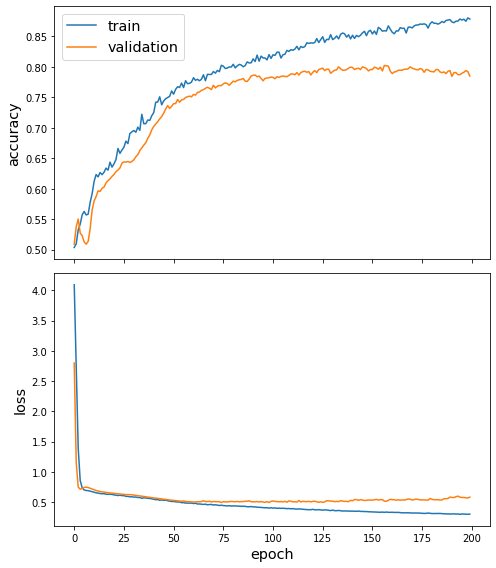

In [19]:
plot_history(history)

In [20]:
train_metrics = model.evaluate(train_gen)
test_metrics = model.evaluate(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3/3 [==============================] - 1s 140ms/step - loss: 0.5878 - accuracy: 0.7860

Train Set Metrics of the trained model:
	loss: 0.2719
	accuracy: 0.8775

Test Set Metrics of the trained model:
	loss: 0.5878
	accuracy: 0.7860
